# Outlier detection in SMACOF solutions

In [1]:
from scripts.ClusterTS_MDS import ClusterVTECDataMDS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
PTEX_dissim = np.loadtxt("./data/PTEX_DTW_matrix.dat", dtype= np.float64, delimiter = ",")
PTEX_dissim.shape

(4912, 4912)

SMACOF-Dissim with 2 components has a stress value of 0.123910


0.12390978827318846

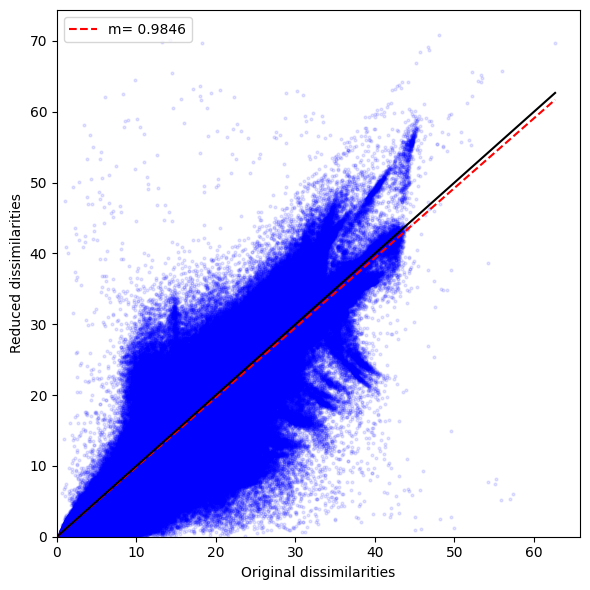

In [3]:
TEC_ClusterSeries = ClusterVTECDataMDS(dissimilarity = PTEX_dissim)
TEC_ClusterSeries.ComputeMDS(num_comps_mds = 2, method = "SMACOF-Dissim")

--Scores with K-Means clustering--
SH coefficient = 0.6987902896116999
CH index = 13385.109975211632
DB index = 0.46948686797546496
--Total series for every cluster--
0 -> 1768
1 -> 2471
2 -> 673


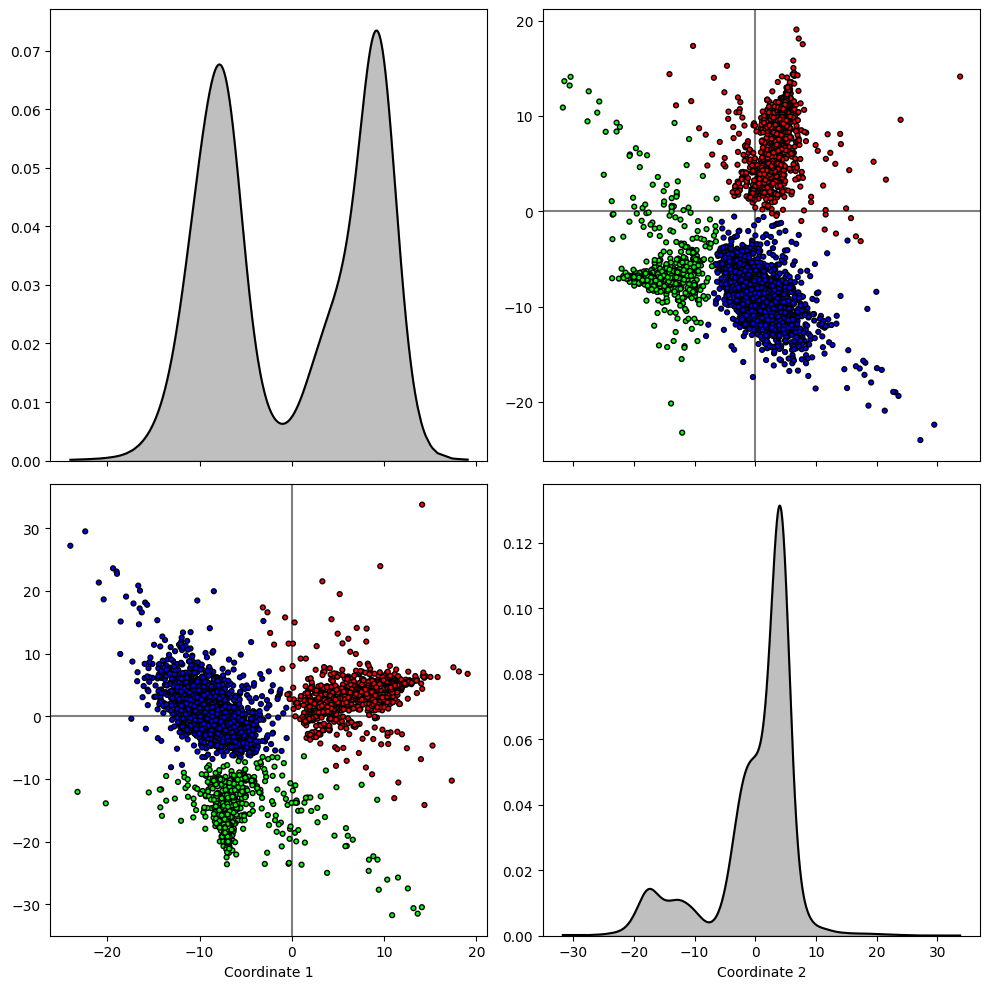

In [4]:
TEC_ClusterSeries.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
TEC_ClusterSeries.VisualizeClustering()

In [5]:
def GetDistancesByCluster(X, Centers, Labels):
    ExistLabels = np.unique(Labels).astype(int)

    DistancesByCluster = dict()
    for Label in ExistLabels:
        DistancesByCluster[Label] = np.sqrt(((X[Labels == Label, :] - Centers[Label - 1, :])**2.0).sum(axis = 1))

    return DistancesByCluster

In [6]:
DistancesByCluster = GetDistancesByCluster(TEC_ClusterSeries.Xc_TS, TEC_ClusterSeries.centers, TEC_ClusterSeries.Xc_Labels)

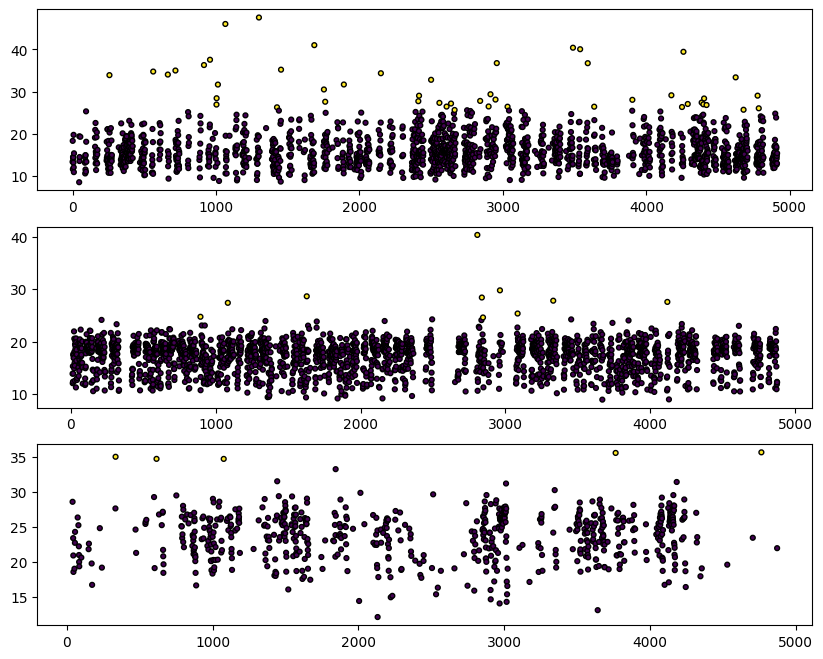

In [7]:
IndicesSeries = np.array(range(TEC_ClusterSeries.Xc_Labels.size))
OutliersOrNot = np.zeros(TEC_ClusterSeries.Xc_Labels.size)

Figure, Subplots = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8))
for Label in np.unique(TEC_ClusterSeries.Xc_Labels):
    Q1 = np.percentile(DistancesByCluster[Label], 25)
    Q3 = np.percentile(DistancesByCluster[Label], 75)
    IQR = Q3 - Q1
    lim_sup = Q3 + 1.5*IQR
    outliers = (DistancesByCluster[Label] > lim_sup).astype(int)

    OutliersOrNot[TEC_ClusterSeries.Xc_Labels == Label] = outliers

    Subplots[Label].scatter(IndicesSeries[TEC_ClusterSeries.Xc_Labels == Label], DistancesByCluster[Label], s = 12, c = outliers, ec = "black")

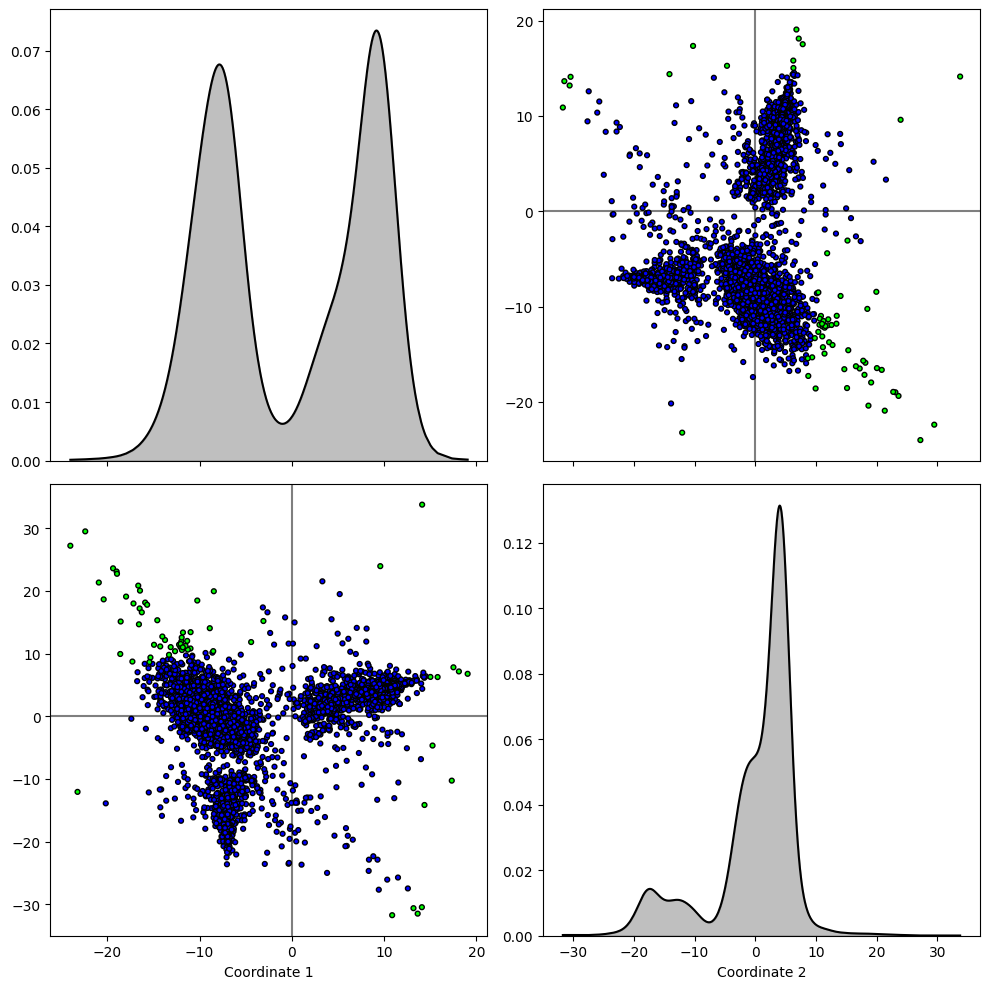

In [8]:
TEC_ClusterSeries.VisualizeClustering(Labels = OutliersOrNot)

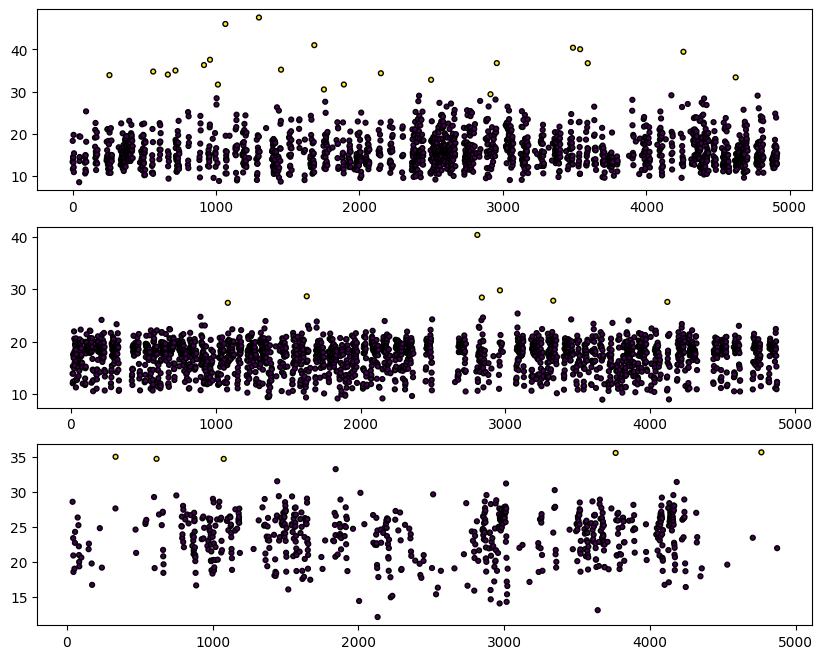

In [9]:
IndicesSeries = np.array(range(TEC_ClusterSeries.Xc_Labels.size))
OutliersOrNot = np.zeros(TEC_ClusterSeries.Xc_Labels.size)

Figure, Subplots = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8))
for Label in np.unique(TEC_ClusterSeries.Xc_Labels):
    mean_dist, std_dist = DistancesByCluster[Label].mean(), DistancesByCluster[Label].std()
    lim_sup = mean_dist + 3.0*std_dist
    outliers = (DistancesByCluster[Label] > lim_sup).astype(int)

    OutliersOrNot[TEC_ClusterSeries.Xc_Labels == Label] = outliers

    Subplots[Label].scatter(IndicesSeries[TEC_ClusterSeries.Xc_Labels == Label], DistancesByCluster[Label], s = 12, c = outliers, ec = "black")

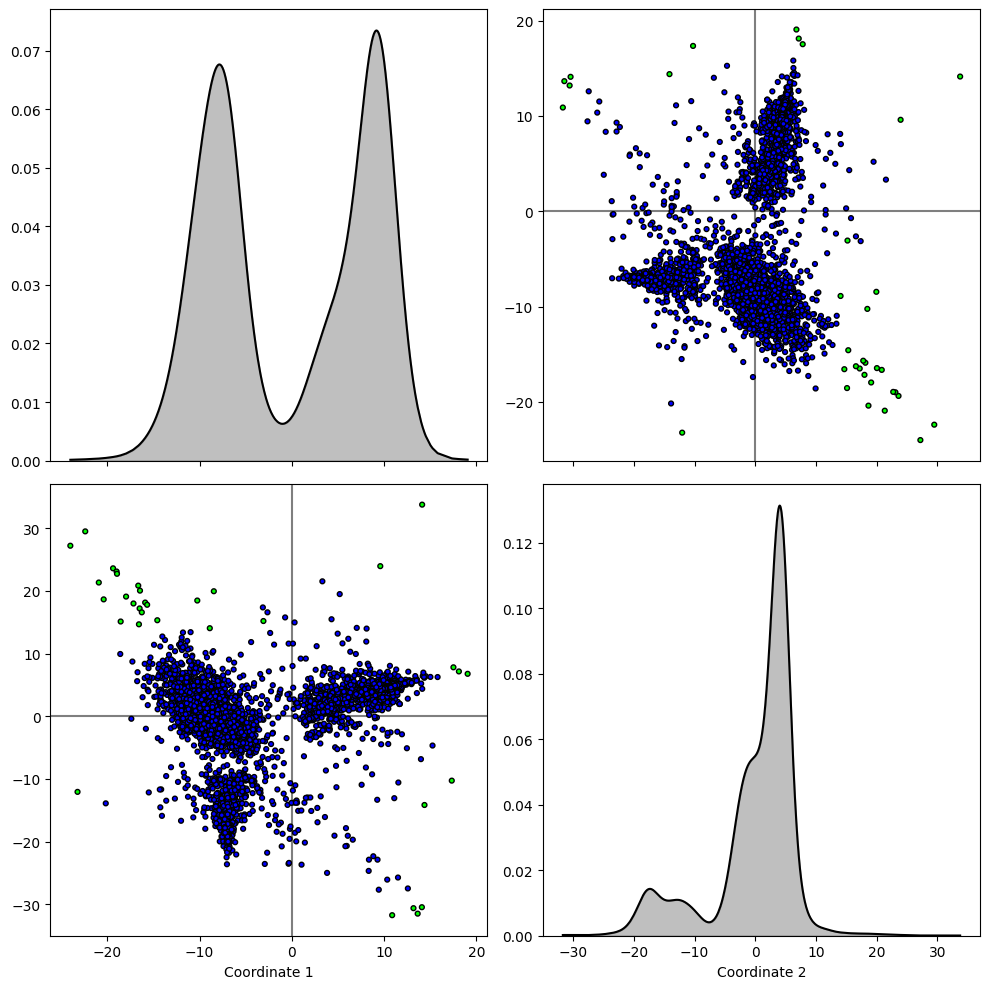

In [10]:
TEC_ClusterSeries.VisualizeClustering(Labels = OutliersOrNot)

In [11]:
min_eps = 1.5
min_samples = 20

DBSCAN_Out = DBSCAN(eps = min_eps, min_samples = min_samples).fit(TEC_ClusterSeries.Xc_TS)
OutliersOrNot = np.where(DBSCAN_Out.labels_ == -1, 1, 0)

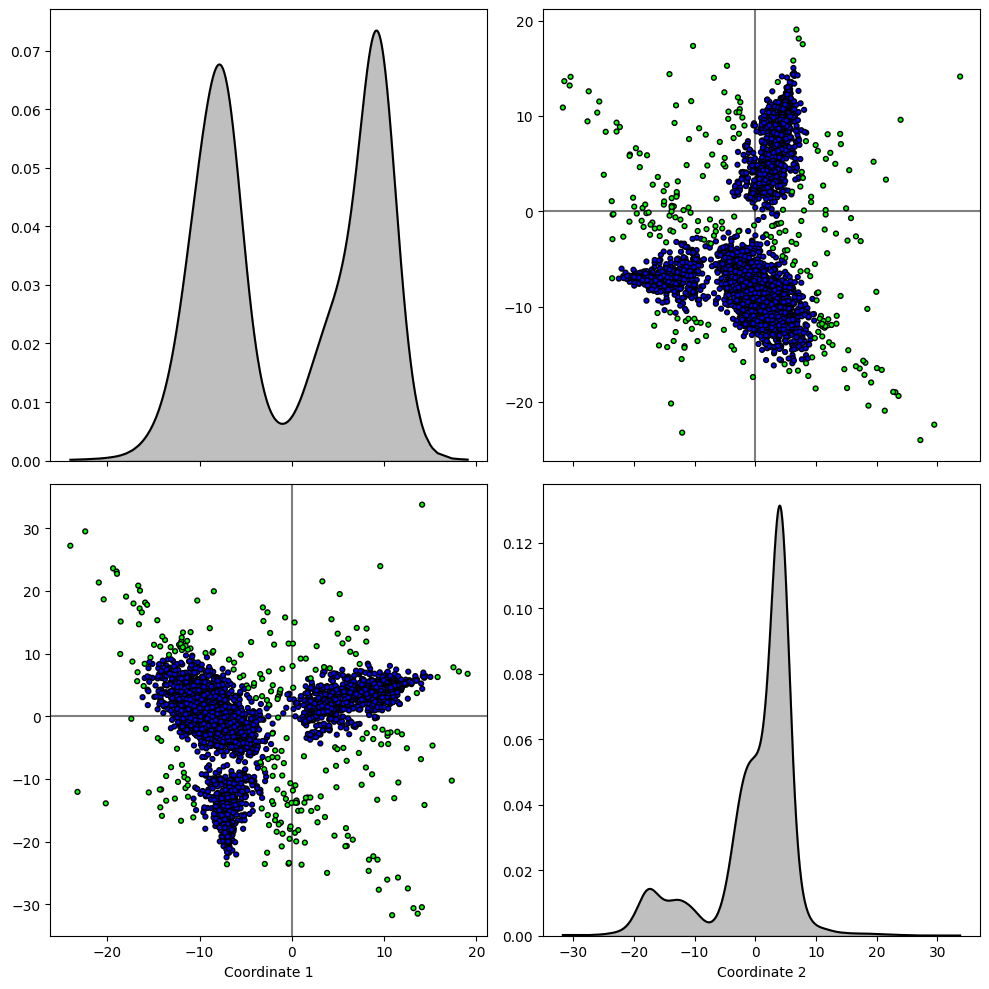

In [12]:
TEC_ClusterSeries.VisualizeClustering(Labels = OutliersOrNot)

## SMACOF solution without outliers given by DBSCAN

In [13]:
def RemoveSameRowsAndColumns(A:np.ndarray, index) -> np.ndarray:
    return np.delete(np.delete(A, index, 0), index, 1)

In [14]:
IndexOutliers = np.argwhere(OutliersOrNot == 1)
IndexNotOutliers = np.argwhere(OutliersOrNot == 0)

print("Number of outliers: ", IndexOutliers.size)

PTEX_red_dissim = RemoveSameRowsAndColumns(PTEX_dissim, IndexOutliers)
PTEX_red_dissim.shape

Number of outliers:  259


(4653, 4653)

SMACOF-Dissim with 2 components has a stress value of 0.102012


0.10201174212608279

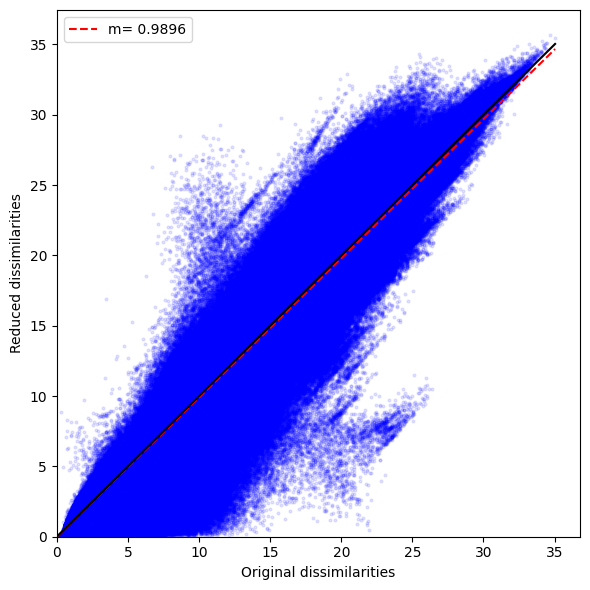

In [15]:
TEC_ClusterSeriesRed = ClusterVTECDataMDS(dissimilarity = PTEX_red_dissim)
TEC_ClusterSeriesRed.ComputeMDS(num_comps_mds = 2, method = "SMACOF-Dissim")

--Scores with K-Means clustering--
SH coefficient = 0.7316097835617936
CH index = 18590.737963871732
DB index = 0.4002082956394932
--Total series for every cluster--
0 -> 1673
1 -> 2405
2 -> 575


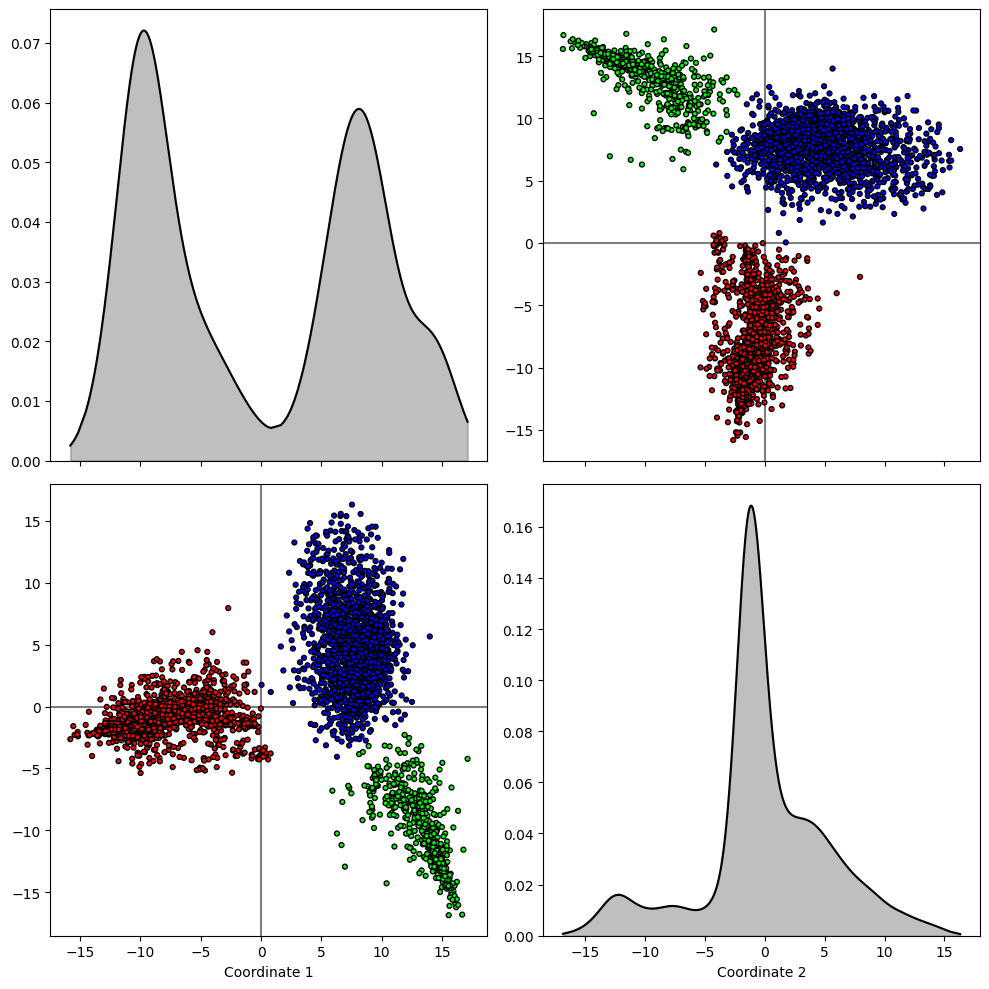

In [16]:
TEC_ClusterSeriesRed.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
TEC_ClusterSeriesRed.VisualizeClustering()

## Save outliers status for all TEC series

In [17]:
CompleteLabels = np.zeros(PTEX_dissim.shape[0], dtype = int)

CompleteLabels[IndexOutliers] = -1
CompleteLabels[IndexNotOutliers] = TEC_ClusterSeriesRed.Xc_Labels.reshape(PTEX_red_dissim.shape[0], 1)

In [18]:
with open("./data/PTEX_Outliers.dat", "+w") as OutlierOuts:
    for n, label in enumerate(CompleteLabels):
        OutlierOuts.write(f"{n}, {label}\n")